# MVDR Beamformer Polar Pattern Analysis

This notebook analyzes the polar pattern (beam pattern) of the Minimum Variance Distortionless Response (MVDR) beamformer.

Steps:
1. **Setup**: Import libraries and define constants.
2. **Audio Generation**: Create a mono test signal (e.g., sine wave).
3. **Array Geometry**: Define microphone array geometry (using placeholder `calculatePos3d`).
4. **MVDR Initialization**: Instantiate the MVDR beamformer class with array geometry and STFT parameters.
5. **Steering Vector**: Calculate the steering vector for the desired look direction.
6. **Analysis Loop**: 
   - Iterate through various incident angles for a test plane wave.
   - Simulate the multi-channel microphone signals for each incident angle.
   - Calculate the STFT of the simulated signals.,
   - Estimate the Spatial Correlation Matrix (SCM) from the simulated signals (this represents the input signal's spatial properties for *that specific angle*).
   - Calculate the MVDR beamformer weights using the *look direction* steering vector and the SCM of the *incident angle* signal.
   - Apply the beamformer weights to the STFT of the *incident angle* signal.
   - Calculate the output power/amplitude of the beamformed signal.
   - Store the angle and the corresponding output power (in dB).
7. **Plotting**: Generate a polar plot showing the beamformer's response (gain) at different angles."

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf # For reading audio if needed
import pandas as pd # For data handling
from typing import Dict, Tuple, Any

# Import the custom modules 
from beamform import util
from beamform import mvdr
import audio_generation

## 1. Setup: Constants and Parameters

In [2]:
# Audio Parameters
TEST_FREQUENCY = 1000  # Hz (Frequency of the test sine wave)
DURATION = 1.0         # seconds (Duration of the test signal)
SAMPLING_FREQUENCY = 16000 # Hz (Ensure this matches MVDR setup)
AUDIO_TYPE = 'clean'   # Options: 'clean' or 'noisy'
SNR_DB = 20           # Signal-to-Noise Ratio in dB (used when AUDIO_TYPE='noisy')

# STFT Parameters (Should match MVDR setup)
FFT_LENGTH = 512
FFT_SHIFT = 256 # 50% overlap is common
FRAME_LENGTH = FFT_LENGTH # Assuming window length equals FFT length

# Array Geometry Parameters
SOUND_SPEED = 343.0     # m/s
MIC_SPACING = 0.04      # meters
NUM_MICS = 8
LOOK_DIRECTION_DEG = 0  # degrees (Angle beamformer is steered towards, 0=broadside)

# Analysis Parameters
NUM_ANGLES_TO_TEST = 500 # Number of points for the polar plot
MIN_ANGLE_DEG = -90
MAX_ANGLE_DEG = 90
DB_THRESHOLD = -50      # Minimum dB value for plotting

## 2. Audio Generation

Generated clean mono audio signal: 16000 samples


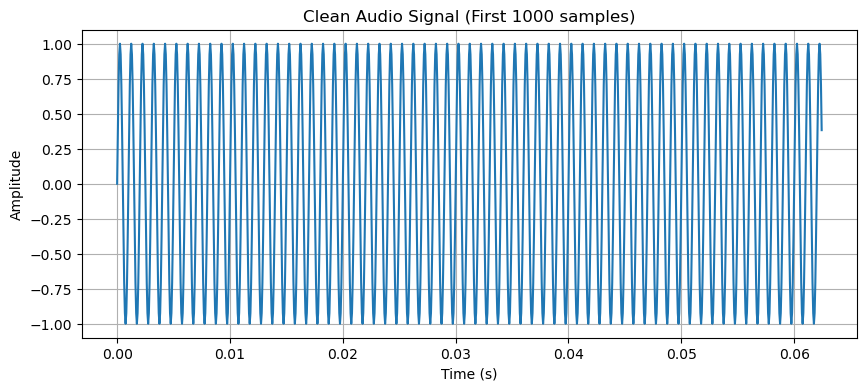

In [3]:
# Generate the test audio signal (clean or noisy)
if AUDIO_TYPE.lower() == 'noisy':
    mono_audio = audio_generation.make_noisy_mono_audio(
        frequency=TEST_FREQUENCY,
        duration=DURATION,
        sampling_rate=SAMPLING_FREQUENCY,
        snr_db=SNR_DB,
        write_file=False # Don't save to file for this analysis
    )
    print(f"Generated noisy mono audio signal with SNR={SNR_DB}dB: {len(mono_audio)} samples")
else: # Default to clean audio
    mono_audio = audio_generation.make_mono_audio(
        frequency=TEST_FREQUENCY,
        duration=DURATION,
        sampling_rate=SAMPLING_FREQUENCY,
        write_file=False # Don't save to file for this analysis
    )
    print(f"Generated clean mono audio signal: {len(mono_audio)} samples")

# Plot a sample of the audio signal
plt.figure(figsize=(10, 4))
sample_length = min(1000, len(mono_audio))  # Show first 1000 samples or all if fewer
plt.plot(np.arange(sample_length)/SAMPLING_FREQUENCY, mono_audio[:sample_length])
plt.title(f"{AUDIO_TYPE.capitalize()} Audio Signal (First {sample_length} samples)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

## 3. Array Geometry

In [4]:
# Calculate microphone positions (m) and the source position vector (s) for the look direction
# Using the placeholder function from util.py (assumes ULA)
# 's' here represents the point/direction the beamformer is steered towards.
source_position_s, mic_positions_m = util.calculatePos3d(
    D=MIC_SPACING, 
    M=NUM_MICS, 
    theta_degrees=LOOK_DIRECTION_DEG
)

print(f"Microphone Positions (m):\\n{mic_positions_m}")
print(f"Look Direction Source Position Vector (s):\\n{source_position_s}")

(ULA assumption).
Microphone Positions (m):\n[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]
Look Direction Source Position Vector (s):\n[[6.123234e-16]
 [1.000000e+01]
 [0.000000e+00]]


## 4. MVDR Initialization

In [5]:
# Instantiate the MVDR beamformer
mvdr_beamformer = mvdr.MinimumVarianceDistortionlessResponse(
    mic_positions_m=mic_positions_m,
    sampling_frequency=SAMPLING_FREQUENCY,
    sound_speed=SOUND_SPEED,
    fft_length=FFT_LENGTH,
    fft_shift=FFT_SHIFT
)

print("MVDR Beamformer Initialized.")

MVDR Beamformer Initialized.


## 5. Steering Vector Calculation

In [6]:
# Calculate the steering vector for the desired look direction
steering_vector_look_direction = mvdr_beamformer.get_steering_vector(source_position_s)

print(f"Calculated steering vector for look direction {LOOK_DIRECTION_DEG} degrees. Shape: {steering_vector_look_direction.shape}")

Calculated steering vector for look direction 0 degrees. Shape: (8, 257)


## 6. Analysis Loop: Calculate Beamformer Response

In [7]:
angle_degrees_arr = []
log_output_arr = []
angle_rad_arr = []

max_angle_response = -np.inf
max_val_response = -np.inf

print(f"Starting analysis loop for {NUM_ANGLES_TO_TEST} angles...")

for i in range(NUM_ANGLES_TO_TEST):
    # Current incident angle being tested
    incident_angle_deg = MIN_ANGLE_DEG + (MAX_ANGLE_DEG - MIN_ANGLE_DEG) * (i / (NUM_ANGLES_TO_TEST - 1))
    incident_angle_rad = np.radians(incident_angle_deg)

    # 1. Simulate multi-channel audio for this incident angle
    multi_channel_audio = audio_generation.delay_across_channels_py_freq(
        mono_audio,
        incident_angle_deg,
        NUM_MICS,
        MIC_SPACING,
        SAMPLING_FREQUENCY,
        SOUND_SPEED
    )

    # 2. Calculate STFT of the simulated signal
    complex_spectrum, _ = util.get_3dim_spectrum_from_data(
        multi_channel_audio,
        FRAME_LENGTH,
        FFT_SHIFT,
        FFT_LENGTH
    )
    # Expected shape: [num_mics, num_frames, num_bins]
    if complex_spectrum is None:
        print(f"Skipping angle {incident_angle_deg} due to STFT error.")
        continue

    # 3. Estimate SCM (using the simulated signal for this incident angle)
    # Note: In a real scenario, SCM is often estimated from noise or a specific signal segment.
    # Here, we use the entire simulated signal to see the response *to that specific input angle*.
    spatial_correlation_matrix = mvdr_beamformer.get_spatial_correlation_matrix(multi_channel_audio)
    # Expected shape: [num_mics, num_mics, num_bins]

    # 4. Calculate MVDR beamformer weights
    # Using the steering vector for the *look direction* and the SCM from the incident angle
    beamformer_weights = mvdr_beamformer.get_mvdr_beamformer(
        steering_vector_look_direction,
        spatial_correlation_matrix
    )
    # Expected shape: [num_mics, num_bins]

    # 5. Apply beamformer weights to the STFT spectrum
    enhanced_speech_spectrum = np.zeros((complex_spectrum.shape[1], complex_spectrum.shape[2]), dtype=np.complex64)
    for f_idx in range(complex_spectrum.shape[2]): # num_bins
        w_f_H = np.conjugate(beamformer_weights[:, f_idx:f_idx+1].T) # Shape [1 x num_mics]
        X_f = complex_spectrum[:, :, f_idx] # Shape [num_mics x num_frames]
        enhanced_speech_spectrum[:, f_idx] = np.dot(w_f_H, X_f)[0, :] # Shape [num_frames]
    
    # Optional: Convert back to time domain if needed for power calculation, 
    # but often power is calculated in frequency domain.
    # enhanced_speech_signal = mvdr_beamformer.apply_beamformer(beamformer_weights, complex_spectrum)

    # 6. Calculate output power/amplitude
    # Method 1: Average power across frames and frequencies (more robust)
    # avg_power = np.mean(np.abs(enhanced_speech_spectrum)**2)
    # output_amplitude = np.sqrt(avg_power) # Amplitude is sqrt of power

    # Method 2: Max absolute value across frames in frequency domain (simpler, used in original notebook)
    # Find the maximum absolute value in the enhanced spectrum
    # Let's calculate power in freq domain for simplicity and robustness.
    # Calculate average power per frame, then average across frames.
    power_per_frame = np.mean(np.abs(enhanced_speech_spectrum)**2, axis=1) # Average power across frequencies for each frame
    average_output_power = np.mean(power_per_frame) # Average power across all frames
    output_amplitude = np.sqrt(average_output_power) # Use sqrt for amplitude-like measure
    
    # Handle potential zero amplitude before log
    if output_amplitude < 1e-9: # Use a small threshold
        log_output = DB_THRESHOLD
    else:
        log_output = 20 * np.log10(output_amplitude)
    
    # Ensure log_output doesn't go below the threshold for plotting
    log_output = max(log_output, DB_THRESHOLD)

    # Store results for plotting
    angle_rad_arr.append(incident_angle_rad)
    angle_degrees_arr.append(incident_angle_deg)
    log_output_arr.append(log_output)

    # Track maximum response
    if log_output > max_val_response:
        max_val_response = log_output
        max_angle_response = incident_angle_deg
        
    if (i + 1) % 50 == 0:
        print(f"Processed angle {i+1}/{NUM_ANGLES_TO_TEST} ({incident_angle_deg:.1f} degrees)")

print("\nAnalysis complete.")
print(f"Maximum response was {max_val_response:.2f} dB at {max_angle_response:.2f} degrees.")

Starting analysis loop for 500 angles...
Processed angle 50/500 (-72.3 degrees)
Processed angle 100/500 (-54.3 degrees)
Processed angle 150/500 (-36.3 degrees)
Processed angle 200/500 (-18.2 degrees)
Processed angle 250/500 (-0.2 degrees)
Processed angle 300/500 (17.9 degrees)
Processed angle 350/500 (35.9 degrees)
Processed angle 400/500 (53.9 degrees)
Processed angle 450/500 (72.0 degrees)
Processed angle 500/500 (90.0 degrees)

Analysis complete.
Maximum response was -14.59 dB at 0.18 degrees.


## 7. Plotting

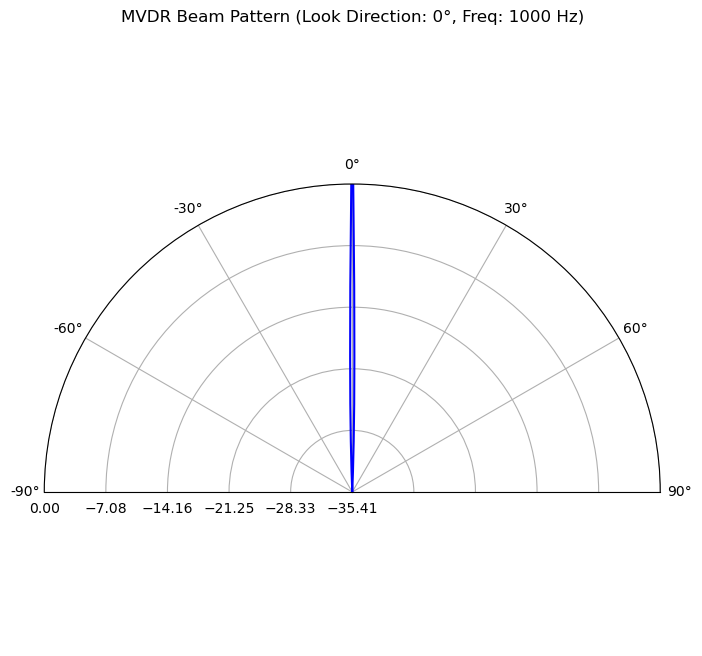

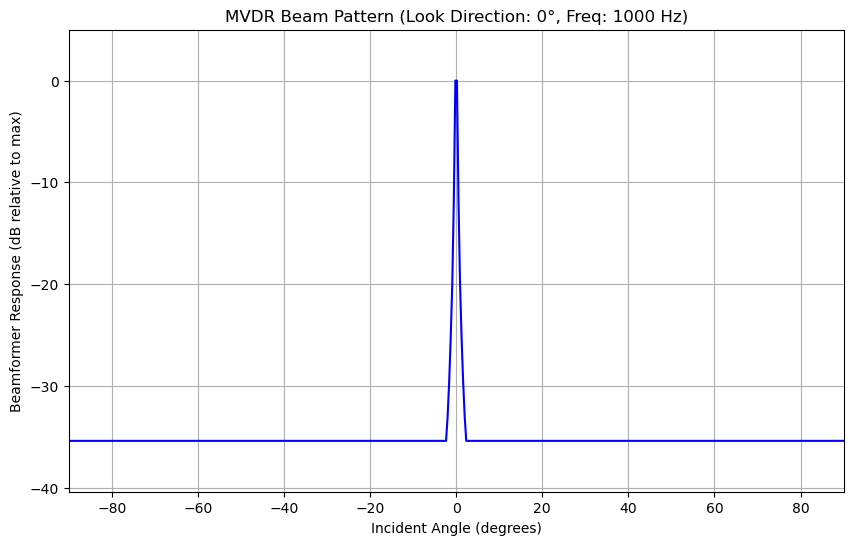

In [8]:
# Normalize the response relative to the maximum for plotting (0 dB at peak)
normalized_log_output = np.array(log_output_arr) - max_val_response

# Ensure the normalized values don't go below the threshold relative to the peak
# (e.g., if threshold is -50, lowest plotted value is max_val - 50)
plot_threshold = DB_THRESHOLD - max_val_response
normalized_log_output_clipped = np.maximum(normalized_log_output, plot_threshold)

# --- Polar Plot ---
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
ax.plot(angle_rad_arr, normalized_log_output_clipped, 'b-')

# Customize the polar plot
ax.set_theta_zero_location('N')  # Set 0 degrees to the top (North)
ax.set_theta_direction(-1)      # Set angles to increase clockwise
ax.set_thetamin(MIN_ANGLE_DEG)
ax.set_thetamax(MAX_ANGLE_DEG)

# Set radial limits (dB scale)
# The outermost circle represents the peak (0 dB)
# The innermost circle represents the threshold (e.g., -50 dB relative to peak)
ax.set_rlim([plot_threshold, 0]) 
ax.set_rticks(np.linspace(plot_threshold, 0, 6)) # Example: 6 ticks from threshold to 0 dB
ax.set_rlabel_position(90) # Position radial labels

plt.title(f'MVDR Beam Pattern (Look Direction: {LOOK_DIRECTION_DEG}°, Freq: {TEST_FREQUENCY} Hz)')
ax.grid(True)
plt.show()

# --- Cartesian Plot ---
plt.figure(figsize=(10, 6))
plt.plot(angle_degrees_arr, normalized_log_output_clipped, 'b-')
plt.xlabel("Incident Angle (degrees)")
plt.ylabel("Beamformer Response (dB relative to max)")
plt.title(f'MVDR Beam Pattern (Look Direction: {LOOK_DIRECTION_DEG}°, Freq: {TEST_FREQUENCY} Hz)')
plt.ylim([plot_threshold - 5, 5]) # Add some padding to y-axis
plt.xlim([MIN_ANGLE_DEG, MAX_ANGLE_DEG])
plt.grid(True)
plt.show()

In [9]:
def get_default_params() -> Dict[str, Any]:
    """Returns a dictionary containing the default parameters for the analysis."""
    params = {
        # Audio Parameters
        "TEST_FREQUENCY": 1000,  # Hz (Frequency of the test sine wave)
        "DURATION": 1.0,         # seconds (Duration of the test signal)
        "SAMPLING_FREQUENCY": 16000, # Hz (Ensure this matches MVDR setup)
        "AUDIO_TYPE": "clean",    # Options: 'clean' or 'noisy'
        "SNR_DB": 20,            # Signal-to-Noise Ratio in dB (for noisy audio)

        # STFT Parameters (Should match MVDR setup)
        "FFT_LENGTH": 512,
        "FFT_SHIFT": 256, # 50% overlap is common
        # Assuming window length equals FFT length for simplicity in this example.
        # If using different window length, adjust functions accordingly.
        "FRAME_LENGTH": 512, # Typically same as FFT_LENGTH

        # Array Geometry Parameters
        "SOUND_SPEED": 343.0,     # m/s
        "MIC_SPACING": 0.04,      # meters
        "NUM_MICS": 8,
        "LOOK_DIRECTION_DEG": 0,  # degrees (Angle beamformer is steered towards, 0=broadside)

        # Analysis Parameters
        "NUM_ANGLES_TO_TEST": 500, # Number of points for the polar plot
        "MIN_ANGLE_DEG": -90,
        "MAX_ANGLE_DEG": 90,

        # MVDR Specific Parameters
        "STABILIZATION_THETA": 1e5, # Condition number threshold for SCM stabilization

        # Plotting Parameters
        "DB_THRESHOLD": -50,      # Minimum dB value for plotting
        "PLOT_TITLE_SUFFIX": ""   # Optional suffix for plot titles
    }
    # Ensure FRAME_LENGTH matches FFT_LENGTH if that's the assumption
    params["FRAME_LENGTH"] = params["FFT_LENGTH"]
    return params


In [10]:
def generate_test_signal(params: Dict[str, Any]) -> np.ndarray:
    """Generates the mono test audio signal based on parameters."""
    print("\n--- Generating Test Signal ---")
    
    if params["AUDIO_TYPE"].lower() == 'noisy':
        mono_audio = audio_generation.make_noisy_mono_audio(
            frequency=params["TEST_FREQUENCY"],
            duration=params["DURATION"],
            sampling_rate=params["SAMPLING_FREQUENCY"],
            snr_db=params["SNR_DB"],
            write_file=False
        )
        print(f"Generated noisy mono audio signal with SNR={params['SNR_DB']}dB: {len(mono_audio)} samples")
    else: # Default to clean audio
        mono_audio = audio_generation.make_mono_audio(
            frequency=params["TEST_FREQUENCY"],
            duration=params["DURATION"],
            sampling_rate=params["SAMPLING_FREQUENCY"],
            write_file=False
        )
        print(f"Generated clean mono audio signal: {len(mono_audio)} samples")
    
# Optional: Plot a sample of the generated audio
    plt.figure(figsize=(10, 4))
    sample_length = min(1000, len(mono_audio))  # Show first 1000 samples or all if fewer
    plt.plot(np.arange(sample_length)/params["SAMPLING_FREQUENCY"], mono_audio[:sample_length])
    plt.title(f"{params['AUDIO_TYPE'].capitalize()} Audio Signal (First {sample_length} samples)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
    
    return mono_audio

def calculate_array_geometry(params: Dict[str, Any]) -> Tuple[np.ndarray, np.ndarray]:
    """Calculates microphone positions and the source position vector for the look direction."""
    print("\n--- Calculating Array Geometry ---")
    # Using the placeholder function from util.py (assumes ULA)
    source_position_s, mic_positions_m = util.calculatePos3d(
        D=params["MIC_SPACING"],
        M=params["NUM_MICS"],
        theta_degrees=params["LOOK_DIRECTION_DEG"]
    )
    print(f"Microphone Positions (m):\n{mic_positions_m}")
    print(f"Look Direction Source Position Vector (s):\n{source_position_s}")
    return source_position_s, mic_positions_m

def initialize_beamformer(params: Dict[str, Any], mic_positions_m: np.ndarray) -> mvdr.MinimumVarianceDistortionlessResponse:
    """Initializes the MVDR beamformer object."""
    print("\n--- Initializing MVDR Beamformer ---")
    mvdr_beamformer = mvdr.MinimumVarianceDistortionlessResponse(
        mic_positions_m=mic_positions_m,
        sampling_frequency=params["SAMPLING_FREQUENCY"],
        sound_speed=params["SOUND_SPEED"],
        fft_length=params["FFT_LENGTH"],
        fft_shift=params["FFT_SHIFT"]
    )
    print("MVDR Beamformer Initialized.")
    return mvdr_beamformer

def calculate_look_direction_steering_vector(beamformer: mvdr.MinimumVarianceDistortionlessResponse,
                                             source_position_s: np.ndarray,
                                             params: Dict[str, Any]) -> np.ndarray:
    """Calculates the steering vector for the desired look direction."""
    print("\n--- Calculating Look Direction Steering Vector ---")
    steering_vector_look_direction = beamformer.get_steering_vector(source_position_s)
    print(f"Calculated steering vector for look direction {params['LOOK_DIRECTION_DEG']} degrees. Shape: {steering_vector_look_direction.shape}")
    return steering_vector_look_direction

def run_beam_pattern_analysis(params: Dict[str, Any],
                              mono_audio: np.ndarray,
                              beamformer: mvdr.MinimumVarianceDistortionlessResponse,
                              steering_vector_look_direction: np.ndarray) -> Dict[str, Any]:
    """Runs the main analysis loop to calculate the beamformer response."""
    print(f"\n--- Starting Analysis Loop ({params['NUM_ANGLES_TO_TEST']} angles) ---")
    angle_degrees_arr = []
    log_output_arr = []
    angle_rad_arr = []

    max_angle_response = -np.inf
    max_val_response = -np.inf

    num_angles = params["NUM_ANGLES_TO_TEST"]
    min_angle = params["MIN_ANGLE_DEG"]
    max_angle = params["MAX_ANGLE_DEG"]

    for i in range(num_angles):
        # Current incident angle being tested
        if num_angles > 1:
            incident_angle_deg = min_angle + (max_angle - min_angle) * (i / (num_angles - 1))
        else:
            incident_angle_deg = min_angle # Handle case of testing only one angle

        incident_angle_rad = np.radians(incident_angle_deg)

        # 1. Simulate multi-channel audio
        multi_channel_audio = audio_generation.delay_across_channels_py_freq(
            mono_audio,
            incident_angle_deg,
            params["NUM_MICS"],
            params["MIC_SPACING"],
            params["SAMPLING_FREQUENCY"],
            params["SOUND_SPEED"]
        )

        # 2. Calculate STFT
        complex_spectrum, _ = util.get_3dim_spectrum_from_data(
            multi_channel_audio,
            params["FRAME_LENGTH"],
            params["FFT_SHIFT"],
            params["FFT_LENGTH"]
        )
        if complex_spectrum is None:
            print(f"Skipping angle {incident_angle_deg:.1f} due to STFT error.")
            continue

        # 3. Estimate SCM
        spatial_correlation_matrix = beamformer.get_spatial_correlation_matrix(multi_channel_audio)

        # 4. Calculate MVDR weights
        beamformer_weights = beamformer.get_mvdr_beamformer(
            steering_vector_look_direction,
            spatial_correlation_matrix,
            params["STABILIZATION_THETA"] # Pass stabilization parameter
        )

        # 5. Apply beamformer weights
        num_frames = complex_spectrum.shape[1]
        num_bins = complex_spectrum.shape[2]
        enhanced_speech_spectrum = np.zeros((num_frames, num_bins), dtype=np.complex64)
        for f_idx in range(num_bins):
            w_f_H = np.conjugate(beamformer_weights[:, f_idx:f_idx+1].T)
            X_f = complex_spectrum[:, :, f_idx]
            enhanced_speech_spectrum[:, f_idx] = np.dot(w_f_H, X_f)[0, :]

        # 6. Calculate output power/amplitude
        power_per_frame = np.mean(np.abs(enhanced_speech_spectrum)**2, axis=1)
        average_output_power = np.mean(power_per_frame)
        output_amplitude = np.sqrt(average_output_power)

        if output_amplitude < 1e-9:
            log_output = params["DB_THRESHOLD"]
        else:
            log_output = 20 * np.log10(output_amplitude)

        log_output = max(log_output, params["DB_THRESHOLD"])

        # Store results
        angle_rad_arr.append(incident_angle_rad)
        angle_degrees_arr.append(incident_angle_deg)
        log_output_arr.append(log_output)

        # Track maximum response
        if log_output > max_val_response:
            max_val_response = log_output
            max_angle_response = incident_angle_deg

        if (i + 1) % 50 == 0 or num_angles < 50:
            print(f"Processed angle {i+1}/{num_angles} ({incident_angle_deg:.1f} degrees)")

    print("\nAnalysis complete.")
    print(f"Maximum response was {max_val_response:.2f} dB at {max_angle_response:.2f} degrees.")

    return {
        "angles_deg": np.array(angle_degrees_arr),
        "angles_rad": np.array(angle_rad_arr),
        "log_outputs": np.array(log_output_arr),
        "max_val_response": max_val_response,
        "max_angle_response": max_angle_response
    }


def plot_beam_pattern(params: Dict[str, Any], analysis_results: Dict[str, Any]):
    """Generates polar and Cartesian plots of the beam pattern."""
    print("\n--- Plotting Results ---")
    angles_deg = analysis_results["angles_deg"]
    angles_rad = analysis_results["angles_rad"]
    log_outputs = analysis_results["log_outputs"]
    max_val_response = analysis_results["max_val_response"]
    db_threshold = params["DB_THRESHOLD"]

    if len(angles_deg) == 0:
        print("No results to plot.")
        return

    # Normalize
    normalized_log_output = log_outputs - max_val_response
    plot_threshold = db_threshold - max_val_response
    normalized_log_output_clipped = np.maximum(normalized_log_output, plot_threshold)

    # Common plot title elements
    title_base = (f"MVDR Beam Pattern (Look={params['LOOK_DIRECTION_DEG']}°, "
                  f"Freq={params['TEST_FREQUENCY']} Hz)")
    title_full = title_base + params.get("PLOT_TITLE_SUFFIX", "")

    # --- Polar Plot ---
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, projection='polar')
    ax.plot(angles_rad, normalized_log_output_clipped, 'b-')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetamin(params["MIN_ANGLE_DEG"])
    ax.set_thetamax(params["MAX_ANGLE_DEG"])
    ax.set_rlim([plot_threshold, 0])
    ax.set_rticks(np.linspace(plot_threshold, 0, 6))
    ax.set_rlabel_position(90)
    plt.title(title_full + "\nPolar Plot")
    ax.grid(True)
    plt.show()

    # --- Cartesian Plot ---
    plt.figure(figsize=(10, 6))
    plt.plot(angles_deg, normalized_log_output_clipped, 'b-')
    plt.xlabel("Incident Angle (degrees)")
    plt.ylabel("Beamformer Response (dB relative to max)")
    plt.title(title_full + "\nCartesian Plot")
    plt.ylim([plot_threshold - 5, 5])
    plt.xlim([params["MIN_ANGLE_DEG"], params["MAX_ANGLE_DEG"]])
    plt.grid(True)
    plt.show()


In [11]:
# --- Configuration for the current run ---
params = get_default_params()

# --- MODIFY PARAMETERS FOR EXPERIMENTATION HERE (base values for now) ---

# Audio Parameters
params["TEST_FREQUENCY"] = 1000      # Hz (Frequency of the test sine wave)
params["DURATION"] = 1.0             # seconds (Duration of the test signal)
params["SAMPLING_FREQUENCY"] = 16000 # Hz (Ensure this matches MVDR setup)
params["AUDIO_TYPE"] = "clean"      # Options: 'clean' or 'noisy'
params["SNR_DB"] = 20               # Signal-to-Noise Ratio in dB (for noisy audio)

# STFT Parameters (Should match MVDR setup)
params["FFT_LENGTH"] = 512           # FFT length
params["FFT_SHIFT"] = 256            # 50% overlap is common
params["FRAME_LENGTH"] = params["FFT_LENGTH"] 

# Array Geometry Parameters
params["SOUND_SPEED"] = 343.0   # m/s
params["MIC_SPACING"] = 0.04    # meters
params["NUM_MICS"] = 8
params["LOOK_DIRECTION_DEG"] = 0  # degrees (Angle beamformer is steered towards, 0=broadside)

# Analysis Parameters
params["NUM_ANGLES_TO_TEST"] = 500 # Number of points for the polar plot
params["MIN_ANGLE_DEG"] = -90
params["MAX_ANGLE_DEG"] = 90

# MVDR Specific Parameters
params["STABILIZATION_THETA"] = 1e5 # Condition number threshold for SCM stabilization

# Plotting Parameters
params["DB_THRESHOLD"] = -50      # Minimum dB value for plotting
params["PLOT_TITLE_SUFFIX"] = ""   # Optional suffix for plot titles

print("Using parameters:")
for key, value in params.items():
    print(f"- {key}: {value}")

Using parameters:
- TEST_FREQUENCY: 1000
- DURATION: 1.0
- SAMPLING_FREQUENCY: 16000
- AUDIO_TYPE: clean
- SNR_DB: 20
- FFT_LENGTH: 512
- FFT_SHIFT: 256
- FRAME_LENGTH: 512
- SOUND_SPEED: 343.0
- MIC_SPACING: 0.04
- NUM_MICS: 8
- LOOK_DIRECTION_DEG: 0
- NUM_ANGLES_TO_TEST: 500
- MIN_ANGLE_DEG: -90
- MAX_ANGLE_DEG: 90
- STABILIZATION_THETA: 100000.0
- DB_THRESHOLD: -50
- PLOT_TITLE_SUFFIX: 



--- Generating Test Signal ---
Generated clean mono audio signal: 16000 samples


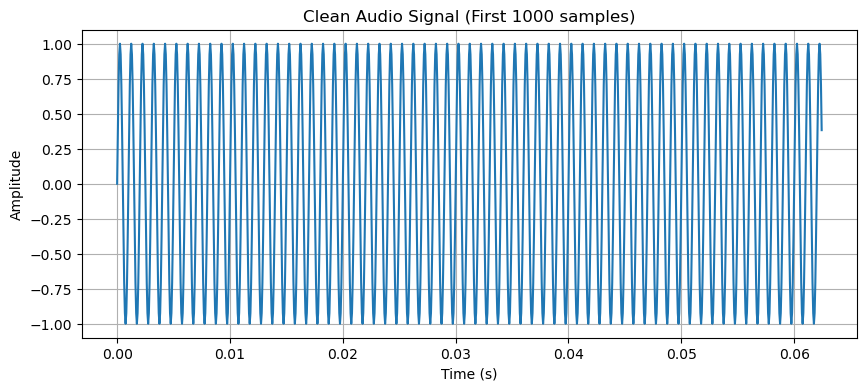


--- Calculating Array Geometry ---
(ULA assumption).
Microphone Positions (m):
[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]
Look Direction Source Position Vector (s):
[[6.123234e-16]
 [1.000000e+01]
 [0.000000e+00]]

--- Initializing MVDR Beamformer ---
MVDR Beamformer Initialized.

--- Calculating Look Direction Steering Vector ---
Calculated steering vector for look direction 0 degrees. Shape: (8, 257)

--- Starting Analysis Loop (500 angles) ---
Processed angle 50/500 (-72.3 degrees)
Processed angle 100/500 (-54.3 degrees)
Processed angle 150/500 (-36.3 degrees)
Processed angle 200/500 (-18.2 degrees)
Processed angle 250/500 (-0.2 degrees)
Processed angle 300/500 (17.9 degrees)
Processed angle 350/500 (35.9 degrees)
Processed angle 400/500 (53.9 degrees)
Processed angle 450/500 (72.0 degrees)
Processed angle 500/500 (90.0 degrees)

Analysis complete.
Maximum response was -14

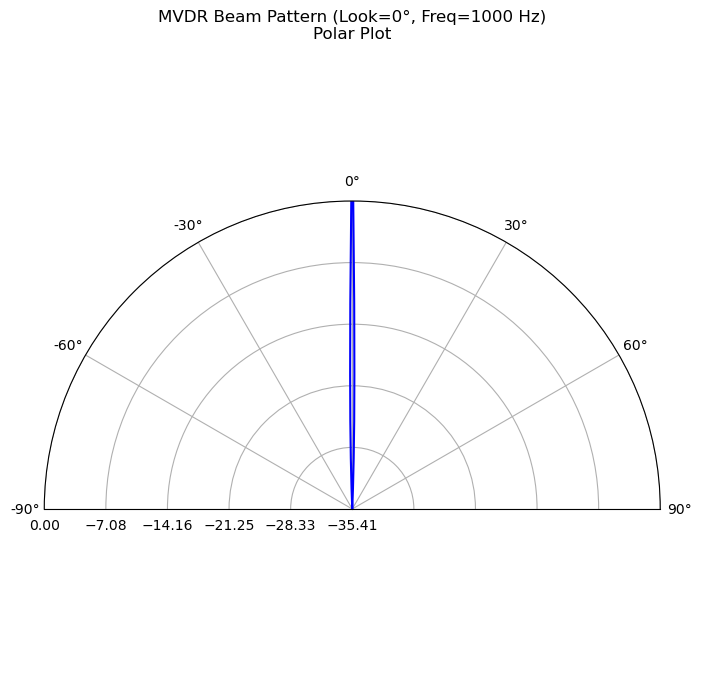

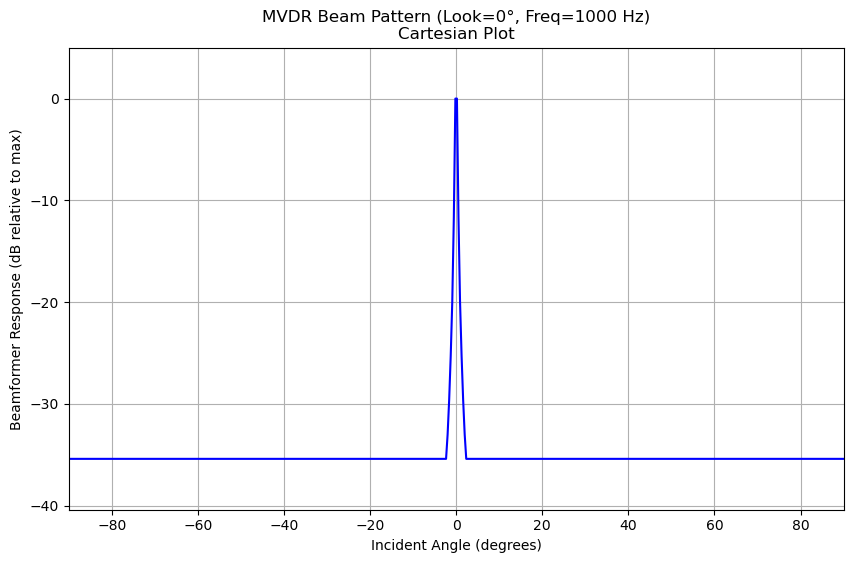


=== Workflow Finished ===


In [12]:
# ==================================================
# Main Analysis Workflow
# ==================================================

# 1. Get Parameters (Defined in Cell 2)
current_params = params

# 2. Generate Test Signal
mono_audio_signal = generate_test_signal(current_params)

# 3. Calculate Array Geometry
source_vec_s, mic_pos_m = calculate_array_geometry(current_params)

# 4. Initialize Beamformer
beamformer_obj = initialize_beamformer(current_params, mic_pos_m)

# 5. Calculate Look Direction Steering Vector
look_steering_vec = calculate_look_direction_steering_vector(beamformer_obj, source_vec_s, current_params)

# 6. Run Analysis Loop
analysis_data = run_beam_pattern_analysis(
    current_params,
    mono_audio_signal,
    beamformer_obj,
    look_steering_vec
)

# 7. Plot Results
plot_beam_pattern(current_params, analysis_data)

print("\n=== Workflow Finished ===")


In [13]:
# --- Configuration for the current run ---
params = get_default_params()

# --- MODIFY PARAMETERS FOR EXPERIMENTATION HERE (base values for now) ---

params["FFT_LENGTH"] = 1024           # FFT length
params["FFT_SHIFT"] = 512            # 50% overlap is common
params["FRAME_LENGTH"] = params["FFT_LENGTH"] 

print("Using parameters:")
for key, value in params.items():
    print(f"- {key}: {value}")

Using parameters:
- TEST_FREQUENCY: 1000
- DURATION: 1.0
- SAMPLING_FREQUENCY: 16000
- AUDIO_TYPE: clean
- SNR_DB: 20
- FFT_LENGTH: 1024
- FFT_SHIFT: 512
- FRAME_LENGTH: 1024
- SOUND_SPEED: 343.0
- MIC_SPACING: 0.04
- NUM_MICS: 8
- LOOK_DIRECTION_DEG: 0
- NUM_ANGLES_TO_TEST: 500
- MIN_ANGLE_DEG: -90
- MAX_ANGLE_DEG: 90
- STABILIZATION_THETA: 100000.0
- DB_THRESHOLD: -50
- PLOT_TITLE_SUFFIX: 



--- Generating Test Signal ---
Generated clean mono audio signal: 16000 samples


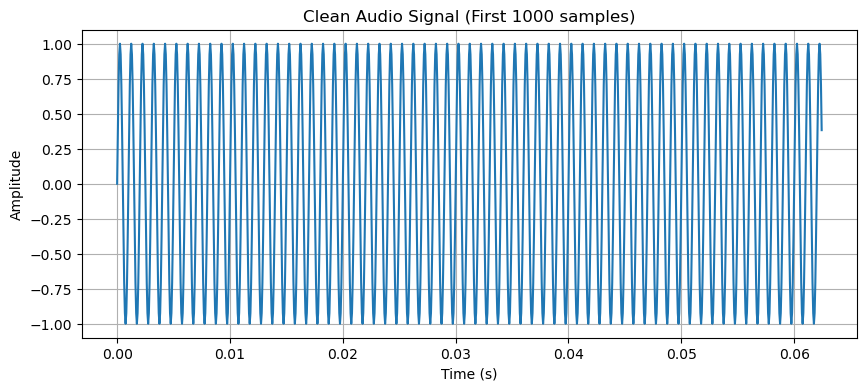


--- Calculating Array Geometry ---
(ULA assumption).
Microphone Positions (m):
[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]
Look Direction Source Position Vector (s):
[[6.123234e-16]
 [1.000000e+01]
 [0.000000e+00]]

--- Initializing MVDR Beamformer ---
MVDR Beamformer Initialized.

--- Calculating Look Direction Steering Vector ---
Calculated steering vector for look direction 0 degrees. Shape: (8, 513)

--- Starting Analysis Loop (500 angles) ---
Processed angle 50/500 (-72.3 degrees)
Processed angle 100/500 (-54.3 degrees)
Processed angle 150/500 (-36.3 degrees)
Processed angle 200/500 (-18.2 degrees)
Processed angle 250/500 (-0.2 degrees)
Processed angle 300/500 (17.9 degrees)
Processed angle 350/500 (35.9 degrees)
Processed angle 400/500 (53.9 degrees)
Processed angle 450/500 (72.0 degrees)
Processed angle 500/500 (90.0 degrees)

Analysis complete.
Maximum response was -23

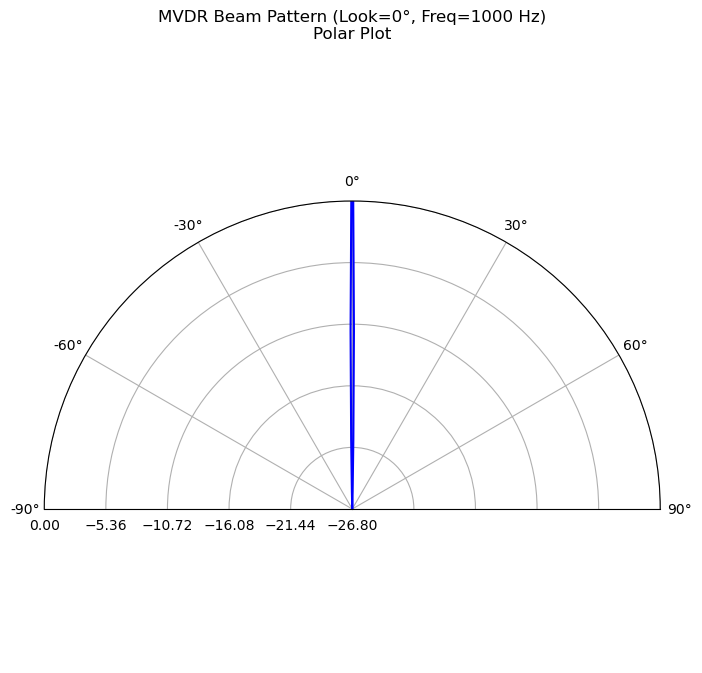

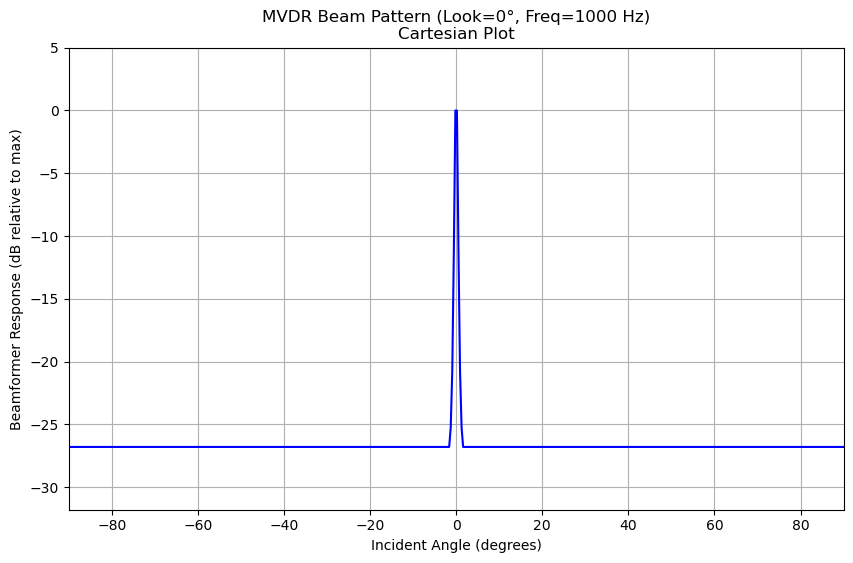


=== Workflow Finished ===


In [14]:
# ==================================================
# Main Analysis Workflow
# ==================================================

# 1. Get Parameters (Defined in Cell 2)
current_params = params

# 2. Generate Test Signal
mono_audio_signal = generate_test_signal(current_params)

# 3. Calculate Array Geometry
source_vec_s, mic_pos_m = calculate_array_geometry(current_params)

# 4. Initialize Beamformer
beamformer_obj = initialize_beamformer(current_params, mic_pos_m)

# 5. Calculate Look Direction Steering Vector
look_steering_vec = calculate_look_direction_steering_vector(beamformer_obj, source_vec_s, current_params)

# 6. Run Analysis Loop
analysis_data = run_beam_pattern_analysis(
    current_params,
    mono_audio_signal,
    beamformer_obj,
    look_steering_vec
)

# 7. Plot Results
plot_beam_pattern(current_params, analysis_data)

print("\n=== Workflow Finished ===")


In [15]:
# --- Configuration for the current run ---
params = get_default_params()

# --- MODIFY PARAMETERS FOR EXPERIMENTATION HERE (base values for now) ---
params["LOOK_DIRECTION_DEG"] = 35  # degrees (Angle beamformer is steered towards, 0=broadside)

print("Using parameters:")
for key, value in params.items():
    print(f"- {key}: {value}")

Using parameters:
- TEST_FREQUENCY: 1000
- DURATION: 1.0
- SAMPLING_FREQUENCY: 16000
- AUDIO_TYPE: clean
- SNR_DB: 20
- FFT_LENGTH: 512
- FFT_SHIFT: 256
- FRAME_LENGTH: 512
- SOUND_SPEED: 343.0
- MIC_SPACING: 0.04
- NUM_MICS: 8
- LOOK_DIRECTION_DEG: 35
- NUM_ANGLES_TO_TEST: 500
- MIN_ANGLE_DEG: -90
- MAX_ANGLE_DEG: 90
- STABILIZATION_THETA: 100000.0
- DB_THRESHOLD: -50
- PLOT_TITLE_SUFFIX: 



--- Generating Test Signal ---
Generated clean mono audio signal: 16000 samples


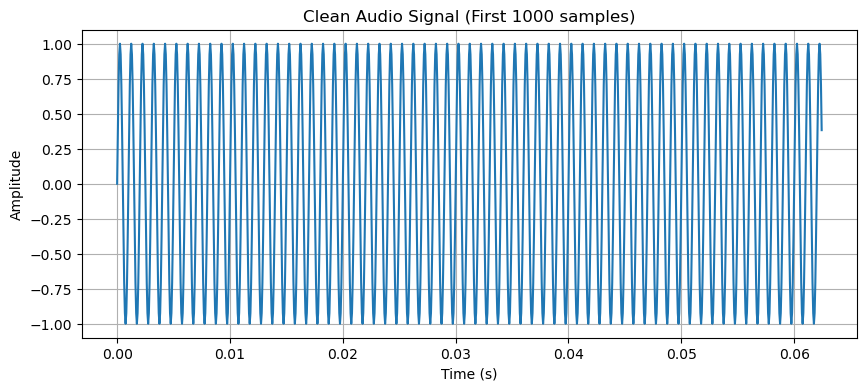


--- Calculating Array Geometry ---
(ULA assumption).
Microphone Positions (m):
[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]
Look Direction Source Position Vector (s):
[[5.73576436]
 [8.19152044]
 [0.        ]]

--- Initializing MVDR Beamformer ---
MVDR Beamformer Initialized.

--- Calculating Look Direction Steering Vector ---
Calculated steering vector for look direction 35 degrees. Shape: (8, 257)

--- Starting Analysis Loop (500 angles) ---
Processed angle 50/500 (-72.3 degrees)
Processed angle 100/500 (-54.3 degrees)
Processed angle 150/500 (-36.3 degrees)
Processed angle 200/500 (-18.2 degrees)
Processed angle 250/500 (-0.2 degrees)
Processed angle 300/500 (17.9 degrees)
Processed angle 350/500 (35.9 degrees)
Processed angle 400/500 (53.9 degrees)
Processed angle 450/500 (72.0 degrees)
Processed angle 500/500 (90.0 degrees)

Analysis complete.
Maximum response was -7.79 dB

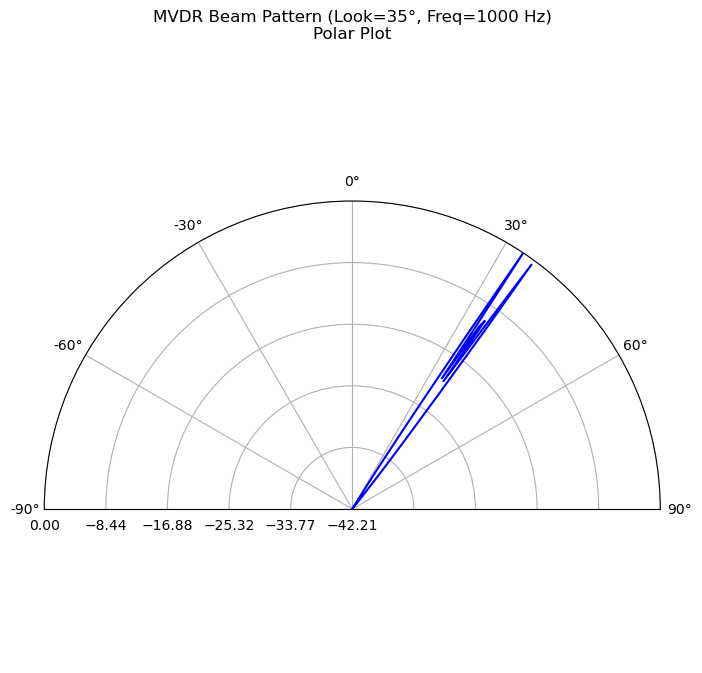

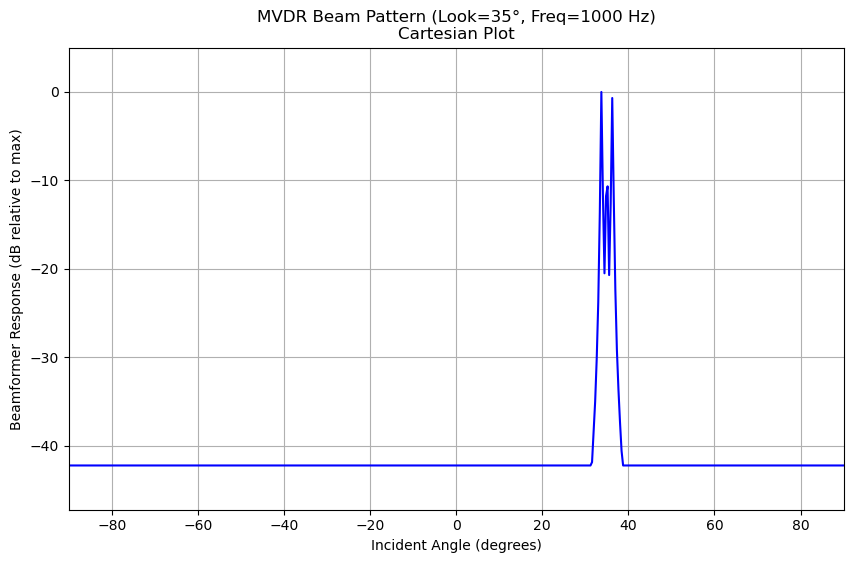


=== Workflow Finished ===


In [16]:
# ==================================================
# Main Analysis Workflow
# ==================================================

# 1. Get Parameters (Defined in Cell 2)
current_params = params

# 2. Generate Test Signal
mono_audio_signal = generate_test_signal(current_params)

# 3. Calculate Array Geometry
source_vec_s, mic_pos_m = calculate_array_geometry(current_params)

# 4. Initialize Beamformer
beamformer_obj = initialize_beamformer(current_params, mic_pos_m)

# 5. Calculate Look Direction Steering Vector
look_steering_vec = calculate_look_direction_steering_vector(beamformer_obj, source_vec_s, current_params)

# 6. Run Analysis Loop
analysis_data = run_beam_pattern_analysis(
    current_params,
    mono_audio_signal,
    beamformer_obj,
    look_steering_vec
)

# 7. Plot Results
plot_beam_pattern(current_params, analysis_data)

print("\n=== Workflow Finished ===")


In [17]:
# --- Configuration for the current run ---
params = get_default_params()

# --- MODIFY PARAMETERS FOR EXPERIMENTATION HERE (base values for now) ---
params["FFT_LENGTH"] = 1024           # FFT length
params["FFT_SHIFT"] = 512            # 50% overlap is common
params["FRAME_LENGTH"] = params["FFT_LENGTH"] 
params["LOOK_DIRECTION_DEG"] = -35  # degrees (Angle beamformer is steered towards, 0=broadside)


print("Using parameters:")
for key, value in params.items():
    print(f"- {key}: {value}")

Using parameters:
- TEST_FREQUENCY: 1000
- DURATION: 1.0
- SAMPLING_FREQUENCY: 16000
- AUDIO_TYPE: clean
- SNR_DB: 20
- FFT_LENGTH: 1024
- FFT_SHIFT: 512
- FRAME_LENGTH: 1024
- SOUND_SPEED: 343.0
- MIC_SPACING: 0.04
- NUM_MICS: 8
- LOOK_DIRECTION_DEG: -35
- NUM_ANGLES_TO_TEST: 500
- MIN_ANGLE_DEG: -90
- MAX_ANGLE_DEG: 90
- STABILIZATION_THETA: 100000.0
- DB_THRESHOLD: -50
- PLOT_TITLE_SUFFIX: 



--- Generating Test Signal ---
Generated clean mono audio signal: 16000 samples


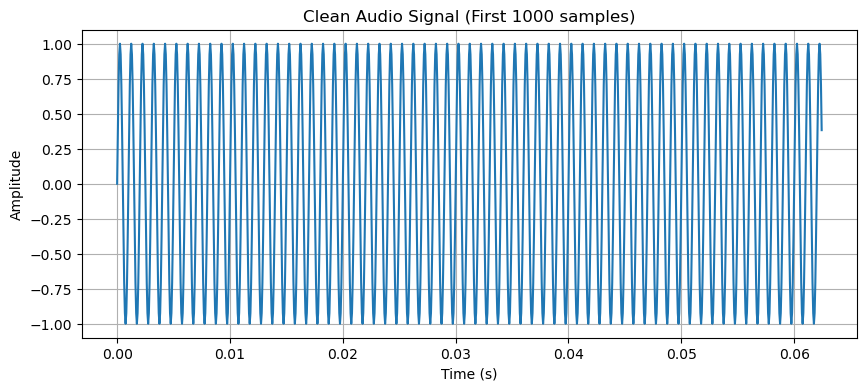


--- Calculating Array Geometry ---
(ULA assumption).
Microphone Positions (m):
[[-0.14 -0.1  -0.06 -0.02  0.02  0.06  0.1   0.14]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.  ]]
Look Direction Source Position Vector (s):
[[-5.73576436]
 [ 8.19152044]
 [ 0.        ]]

--- Initializing MVDR Beamformer ---
MVDR Beamformer Initialized.

--- Calculating Look Direction Steering Vector ---
Calculated steering vector for look direction -35 degrees. Shape: (8, 513)

--- Starting Analysis Loop (500 angles) ---
Processed angle 50/500 (-72.3 degrees)
Processed angle 100/500 (-54.3 degrees)
Processed angle 150/500 (-36.3 degrees)
Processed angle 200/500 (-18.2 degrees)
Processed angle 250/500 (-0.2 degrees)
Processed angle 300/500 (17.9 degrees)
Processed angle 350/500 (35.9 degrees)
Processed angle 400/500 (53.9 degrees)
Processed angle 450/500 (72.0 degrees)
Processed angle 500/500 (90.0 degrees)

Analysis complete.
Maximum response was -17.

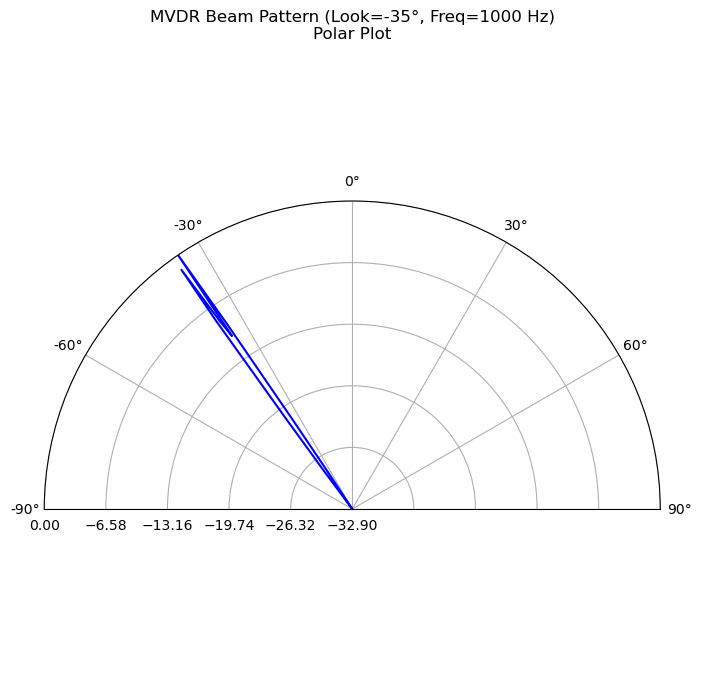

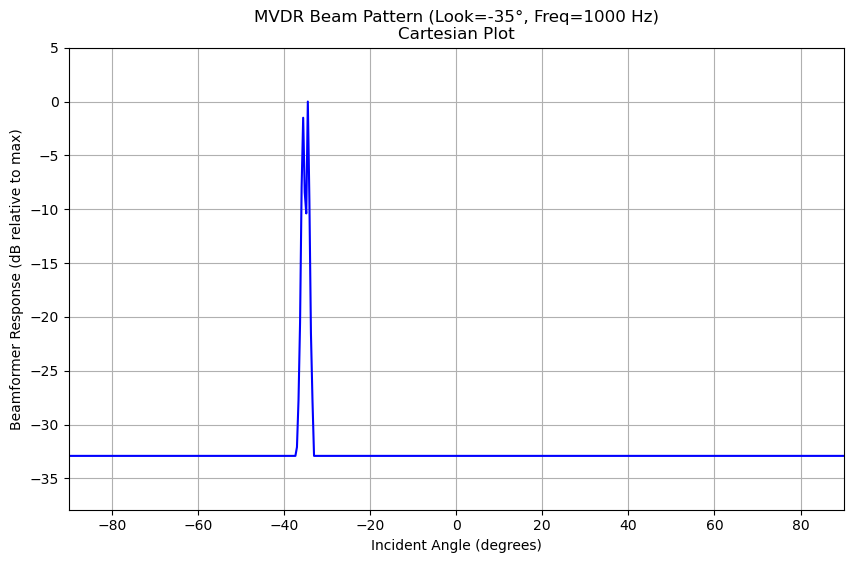


=== Workflow Finished ===


In [18]:
# ==================================================
# Main Analysis Workflow
# ==================================================

# 1. Get Parameters (Defined in Cell 2)
current_params = params

# 2. Generate Test Signal
mono_audio_signal = generate_test_signal(current_params)

# 3. Calculate Array Geometry
source_vec_s, mic_pos_m = calculate_array_geometry(current_params)

# 4. Initialize Beamformer
beamformer_obj = initialize_beamformer(current_params, mic_pos_m)

# 5. Calculate Look Direction Steering Vector
look_steering_vec = calculate_look_direction_steering_vector(beamformer_obj, source_vec_s, current_params)

# 6. Run Analysis Loop
analysis_data = run_beam_pattern_analysis(
    current_params,
    mono_audio_signal,
    beamformer_obj,
    look_steering_vec
)

# 7. Plot Results
plot_beam_pattern(current_params, analysis_data)

print("\n=== Workflow Finished ===")
